This notebooks uses GAN trained on oxford-100 flower dataset to generate the images.

In [2]:
!pip install pytorch-lightning

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super().__init__()
        self.model = nn.Sequential(
            # Starting size: (latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # Size: (512, 4, 4)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Size: (256, 8, 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Size: (128, 16, 16)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Size: (64, 32, 32)
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Final size: (img_channels, 64, 64)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super().__init__()
        self.model = nn.Sequential(
            # Input size: (img_channels, 64, 64)
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (64, 32, 32)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (128, 16, 16)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (256, 8, 8)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (512, 4, 4)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # Output size: (1, 1, 1)
        )

    def forward(self, img):
        return self.model(img)

In [9]:
class DCGAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002, b1=0.5, b2=0.999, batch_size=64, img_channels=3):
        super().__init__()
        self.save_hyperparameters()

        self.latent_dim = latent_dim
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.batch_size = batch_size

        self.generator = Generator(latent_dim=self.latent_dim, img_channels=img_channels)
        self.discriminator = Discriminator(img_channels=img_channels)

        self.validation_z = torch.randn(8, self.latent_dim, 1, 1)

        # Important: This property activates manual optimization.
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return nn.BCELoss()(y_hat, y)

    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        opt_g, opt_d = self.optimizers()

        # sample noise
        z = torch.randn(imgs.shape[0], self.latent_dim, 1, 1)
        z = z.type_as(imgs)

        # train generator
        self.toggle_optimizer(opt_g)
        self.generated_imgs = self(z)
        valid = torch.ones(imgs.size(0), 1, 1, 1)
        valid = valid.type_as(imgs)

        g_loss = self.adversarial_loss(self.discriminator(self.generated_imgs), valid)
        self.log("g_loss", g_loss, prog_bar=True)

        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()
        self.untoggle_optimizer(opt_g)

        # train discriminator
        self.toggle_optimizer(opt_d)
        valid = torch.ones(imgs.size(0), 1, 1, 1)
        valid = valid.type_as(imgs)

        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

        fake = torch.zeros(imgs.size(0), 1, 1, 1)
        fake = fake.type_as(imgs)

        fake_loss = self.adversarial_loss(
            self.discriminator(self(z).detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        self.log("d_loss", d_loss, prog_bar=True)

        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()
        self.untoggle_optimizer(opt_d)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        return [opt_g, opt_d]

    def on_epoch_end(self):
        z = self.validation_z.to(self.device)

        # log sampled images
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

In [10]:
if __name__ == "__main__":
    # Set your data directory
    data_dir = "/content/drive/MyDrive/Data/Oxford-flowers/dataset/train"

    # Hyperparameters
    latent_dim = 100
    lr = 0.0002
    b1 = 0.5
    b2 = 0.999
    batch_size = 64
    num_epochs = 200
    img_channels = 3

    # Create data loader
    train_loader = get_dataloader(data_dir, batch_size=batch_size)

    # Initialize model
    model = DCGAN(latent_dim=latent_dim, lr=lr, b1=b1, b2=b2, batch_size=batch_size, img_channels=img_channels)

    # Logger
    logger = TensorBoardLogger("tb_logs", name="flower_dcgan")

    # Callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor="g_loss",
        dirpath="checkpoints",
        filename="flower_dcgan-{epoch:02d}-{g_loss:.2f}",
        save_top_k=3,
        mode="min",
    )

    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        logger=logger,
        callbacks=[checkpoint_callback],
    )

    # Train the model
    trainer.fit(model, train_loader)

    print("Training completed!")
    print(f"Checkpoints saved to {checkpoint_callback.dirpath}")
    torch.save(model.state_dict(), 'flower_dcgan.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 3.6 M

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Training completed!


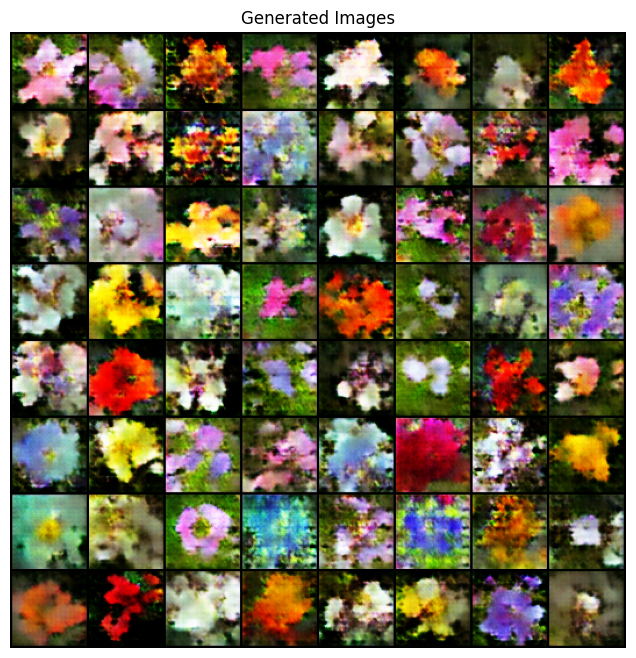

In [26]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(999)

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load the trained generator model
latent_dim = 100  # This should match the latent_dim used during training
img_channels = 3  # This should match the img_channels used during training


# Number of images to generate
num_images = 64

# Load the trained generator model
checkpoint = torch.load('/content/checkpoints/flower_dcgan-epoch=19-g_loss=1.50.ckpt', map_location=device)
model = DCGAN(latent_dim=latent_dim, img_channels=img_channels).to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# Move the model to the appropriate device
model.to(device)

# Create batch of latent vectors
noise = torch.randn(num_images, latent_dim, 1, 1, device=device)

# Generate fake images
with torch.no_grad():
    fake_images = model(noise).detach().cpu()

# Rescale images from [-1, 1] to [0, 1]
fake_images = (fake_images + 1) / 2.0

# Plot the fake images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1,2,0)))
plt.show()

# Save individual images
for i in range(num_images):
    vutils.save_image(fake_images[i], f'generated_image_{i}.png')